The dataset contains dissolved gas analysis (DGA) values such as Hydrogen, Methane, Ethylene, etc., as well as other parameters like Power factor, Health index, Water content and Predicted Life expectation. Based on this, we can augment the data by generating synthetic values for transformer operating data, environmental data, and maintenance history.

#### Plan:
* Calculate the gas ratios (CO/H2, CH4/H2, C2H4/H2, C2H2/H2) from the DGA values.
* Based on these ratios, introduce maintenance events like "emergency maintenance."
* Generate synthetic operational and environmental data (e.g., load, temperature, humidity).
* Add relevant columns like MaintenanceType, Alerts, MaintenanceDate.

In [7]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from numpy.random import poisson
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
# Load CSV file to analyze its content
file_path = 'failure_data/Health index1.csv'
health_index_data = pd.read_csv(file_path)

In [9]:
# transform health_index_data to JSON format for example 
health_index_data.iloc[0].to_json()

'{"Hydrogen":2845.0,"Oxigen":5860.0,"Nitrogen":27842.0,"Methane":7406.0,"CO":32.0,"CO2":1344.0,"Ethylene":16684.0,"Ethane":5467.0,"Acethylene":7.0,"DBDS":19.0,"Power factor":1.0,"Interfacial V":45.0,"Dielectric rigidity":55.0,"Water content":0.0,"Health index":95.2,"Life expectation":19.0}'

In [10]:
# Feature engineering
# Calculate gas ratios related to Overheating and arcing
health_index_data['CO_H2_ratio'] = [health_index_data['CO'][i]/health_index_data['Hydrogen'][i] if health_index_data['Hydrogen'][i] != 0 else 0 for i in range(len(health_index_data))]
health_index_data['CH4_H2_ratio'] = [health_index_data['Methane'][i]/health_index_data['Hydrogen'][i] if health_index_data['Hydrogen'][i] != 0 else 0 for i in range(len(health_index_data))] 
health_index_data['C2H4_H2_ratio'] = [health_index_data['Ethylene'][i]/health_index_data['Hydrogen'][i] if health_index_data['Hydrogen'][i] != 0 else 0 for i in range(len(health_index_data))]  
health_index_data['C2H2_H2_ratio'] = [health_index_data['Acethylene'][i]/health_index_data['Hydrogen'][i] if health_index_data['Hydrogen'][i] != 0 else 0 for i in range(len(health_index_data))]  

# Calculate gas ratios related to Insulation Degradation
health_index_data['H2_N2_ratio'] = [health_index_data['Hydrogen'][i]/health_index_data['Nitrogen'][i] if health_index_data['Nitrogen'][i] != 0 else 0 for i in range(len(health_index_data))]  
health_index_data['O2_N2_ratio'] = [health_index_data['Oxigen'][i]/health_index_data['Nitrogen'][i] if health_index_data['Nitrogen'][i] != 0 else 0 for i in range(len(health_index_data))]  

# Calculate gas ratios related to Moisture
health_index_data['H2_CO2_ratio'] = [health_index_data['Hydrogen'][i]/health_index_data['CO2'][i] if health_index_data['CO2'][i] != 0 else 0 for i in range(len(health_index_data))]  

# Display the first few rows of the data to understand its structure
health_index_data.head()

,Hydrogen,Oxigen,Nitrogen,Methane,CO,CO2,Ethylene,Ethane,Acethylene,DBDS,...,Water content,Health index,Life expectation,CO_H2_ratio,CH4_H2_ratio,C2H4_H2_ratio,C2H2_H2_ratio,H2_N2_ratio,O2_N2_ratio,H2_CO2_ratio
0,2845,5860,27842,7406,32,1344,16684,5467,7,19.0,...,0,95.2,19.0,0.011248,2.603163,5.864323,0.002460,0.102184,0.210473,2.116815
1,12886,61,25041,877,83,864,4,305,0,45.0,...,0,85.5,19.0,0.006441,0.068058,0.000310,0.000000,0.514596,0.002436,14.914352
2,2820,16400,56300,144,257,1080,206,11,2190,1.0,...,11,85.3,19.0,0.091135,0.051064,0.073050,0.776596,0.050089,0.291297,2.611111
3,1099,70,37520,545,184,1402,6,230,0,87.0,...,5,85.3,6.0,0.167425,0.495905,0.005460,0.000000,0.029291,0.001866,0.783880
4,3210,3570,47900,160,360,2130,4,43,4,1.0,...,3,85.2,6.0,0.112150,0.049844,0.001246,0.001246,0.067015,0.074530,1.507042


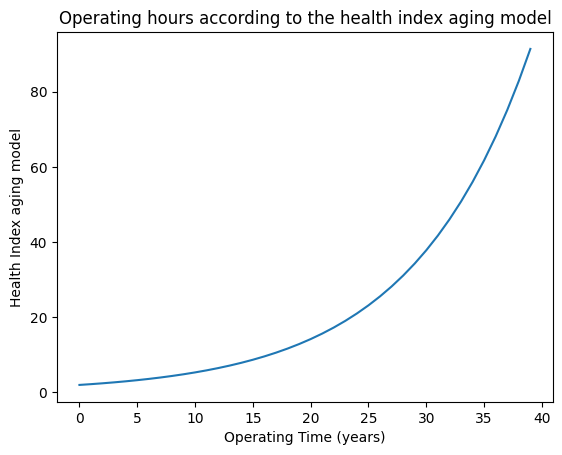

In [11]:
# Simulate Operating hours according to the health index aging model
t = np.arange(0, 40)
exponential_function = 2 * np.exp(0.098 * t)

# plot the exponential function
plt.plot(t, exponential_function)
plt.xlabel("Operating Time (years)")
plt.ylabel("Health Index aging model")
plt.title("Operating hours according to the health index aging model")
plt.show()

In [12]:
# Function to generate random date within a range
def random_date(start, end):
    return start + timedelta(days=random.randint(0, (end - start).days))

# Function to generate synthetic transformer data
def generate_transformer_data(row):
    # Maintenance Type based on gas ratios
    if row['Hydrogen'] > 0 and row['C2H4_H2_ratio'] > 4 or row['H2_N2_ratio']  > 0.2:
        maintenance_type = 'Emergency Maintenance'
    elif row['Hydrogen'] > 0 and row['C2H4_H2_ratio'] <= 0.5 or row['H2_N2_ratio'] <= 0.05:
        maintenance_type = 'Preventive Maintenance'
    else:
        maintenance_type =  'Corrective Maintenance'

    # Alerts based on temperature
    temperature = random.uniform(20, 100)  # Synthetic temperature
    alert = 'High Temperature Alert' if temperature > 90 else 'None'

    # Generate random values for environmental data
    humidity = random.uniform(20, 100)
    precipitation = random.uniform(0, 50) 
    
    # Generate synthetic transformer load and operational data
    load = random.uniform(50, 2000)  # Load in KW
    load_condition = 'High Load' if load > 1500 else 'Normal Load'

    # Create synthetic maintenance and operational records
    maintenance_schedule = random_date(datetime(2020, 1, 1), datetime(2024, 1, 1))
    maintenance_date = random_date(maintenance_schedule, datetime(2024, 1, 1))
    replacement_history = "Replaced major components" if maintenance_type == 'Emergency Maintenance' else "No major replacements"
    
    # Using Poisson distribution to model rare events like storms (mean 0.2 for a rare event)
    incident_poisson = poisson(lam=0.2)
    if incident_poisson > 0:
        incident_type = 'Storm' 
        incident_details = 'Severe weather affecting transformer'
    else:
        # Generate random IncidentType and IncidentDetails (e.g., storm, flood, lightning)
        incident_type = np.random.choice(['None', 'Lightning Strike', 'Flood'], 1, p=[0.8, 0.1, 0.1])[0]
        incident_details = 'No incidents' if incident_type == 'None' else f'{incident_type} occurred causing minor damage'

    # Performance metrics (incorporate summary of operating conditions + incidents)
    performance_metrics = f'Performance with a load of {load} KW and temperature {temperature}°C. '
    if incident_type == 'None':
        performance_metrics = performance_metrics + f'Stable operating conditions without any Incidents'
    else:
        performance_metrics = performance_metrics + f'Operating conditions were impacted by {incident_details}.'
  
    # Model OperatingHours based on the HI aging model, approx with 2 * np.exp(0.098 * t), find t for which the exponential_function reflects the HI aging
    operating_time = (np.log(row['Health index']/2))/0.098 
    
    return pd.Series({
        'TransformerID': f'TxID_{random.randint(1000, 9999)}',
        'InstallationDate': random_date(datetime(2000, 1, 1), datetime(2015, 1, 1)),
        'MaintenanceSchedule': maintenance_schedule,
        'ReplacementHistory': replacement_history,
        'MaintenanceID': f'MNT-{random.randint(10000, 99999)}',
        'MaintenanceType': maintenance_type,
        'MaintenanceDate': maintenance_date,
        'TransformerLoad': load,
        'Temperature': temperature, 
        'Humidity': humidity,
        'Precipitation': precipitation,
        'Alerts': alert,
        'IncidentType': incident_type,
        'IncidentDetails': incident_details, 
        'OperationID': f'OP-{random.randint(1000, 9999)}',
        'OperatingTime': operating_time,
        'LoadCondition': load_condition,
        'PerformanceMetrics': performance_metrics
    })

In [13]:
# test it
row = health_index_data.iloc[10]
print(row)

Hydrogen                   4.000000
Oxigen                 26100.000000
Nitrogen               60600.000000
Methane                    1.000000
CO                       206.000000
CO2                     1440.000000
Ethylene                  13.000000
Ethane                     0.000000
Acethylene                13.000000
DBDS                       5.000000
Power factor               1.320000
Interfacial V             40.000000
Dielectric rigidity       56.000000
Water content              4.000000
Health index              63.400000
Life expectation           6.000000
CO_H2_ratio               51.500000
CH4_H2_ratio               0.250000
C2H4_H2_ratio              3.250000
C2H2_H2_ratio              3.250000
H2_N2_ratio                0.000066
O2_N2_ratio                0.430693
H2_CO2_ratio               0.002778
Name: 10, dtype: float64


In [14]:
output_row = generate_transformer_data(row)
print(output_row)
print(output_row['PerformanceMetrics'])

TransformerID                                                  TxID_8064
InstallationDate                                     2003-07-10 00:00:00
MaintenanceSchedule                                  2022-10-05 00:00:00
ReplacementHistory                                 No major replacements
MaintenanceID                                                  MNT-89095
MaintenanceType                                   Preventive Maintenance
MaintenanceDate                                      2023-08-30 00:00:00
TransformerLoad                                              1438.509843
Temperature                                                     57.99916
Humidity                                                       79.486794
Precipitation                                                   0.816546
Alerts                                                              None
IncidentType                                                        None
IncidentDetails                                    

In [15]:
# Apply the synthetic data generation to each row of the original dataframe
synthetic_data = health_index_data.apply(generate_transformer_data, axis=1)
synthetic_data.head()

,TransformerID,InstallationDate,MaintenanceSchedule,ReplacementHistory,MaintenanceID,MaintenanceType,MaintenanceDate,TransformerLoad,Temperature,Humidity,Precipitation,Alerts,IncidentType,IncidentDetails,OperationID,OperatingTime,LoadCondition,PerformanceMetrics
0,TxID_1872,2014-12-15,2022-09-26,Replaced major components,MNT-67527,Emergency Maintenance,2023-08-31,327.902485,83.597670,42.083960,15.846909,None,None,No incidents,OP-3509,39.416661,Normal Load,Performance with a load of 327.90248545686734 ...
1,TxID_4800,2010-10-11,2020-12-01,Replaced major components,MNT-19926,Emergency Maintenance,2022-11-14,1037.272820,58.271030,94.203417,39.936674,None,None,No incidents,OP-1616,38.320094,Normal Load,Performance with a load of 1037.2728204812988 ...
2,TxID_9915,2014-05-17,2021-05-16,No major replacements,MNT-92372,Preventive Maintenance,2023-08-19,1579.934490,58.892251,50.809745,20.301953,None,None,No incidents,OP-4139,38.296197,High Load,Performance with a load of 1579.9344904102502 ...
3,TxID_3641,2011-01-06,2023-06-21,No major replacements,MNT-62720,Preventive Maintenance,2023-07-21,814.984850,28.849592,51.895361,46.499192,None,None,No incidents,OP-8875,38.296197,Normal Load,Performance with a load of 814.9848496434428 K...
4,TxID_7002,2011-02-03,2020-07-15,No major replacements,MNT-13598,Preventive Maintenance,2021-12-07,567.017163,38.966968,60.277677,0.148477,None,None,No incidents,OP-8798,38.284227,Normal Load,Performance with a load of 567.0171626278617 K...


In [16]:
# Display the augmented data 
synthetic_data.head()

,TransformerID,InstallationDate,MaintenanceSchedule,ReplacementHistory,MaintenanceID,MaintenanceType,MaintenanceDate,TransformerLoad,Temperature,Humidity,Precipitation,Alerts,IncidentType,IncidentDetails,OperationID,OperatingTime,LoadCondition,PerformanceMetrics
0,TxID_1872,2014-12-15,2022-09-26,Replaced major components,MNT-67527,Emergency Maintenance,2023-08-31,327.902485,83.597670,42.083960,15.846909,None,None,No incidents,OP-3509,39.416661,Normal Load,Performance with a load of 327.90248545686734 ...
1,TxID_4800,2010-10-11,2020-12-01,Replaced major components,MNT-19926,Emergency Maintenance,2022-11-14,1037.272820,58.271030,94.203417,39.936674,None,None,No incidents,OP-1616,38.320094,Normal Load,Performance with a load of 1037.2728204812988 ...
2,TxID_9915,2014-05-17,2021-05-16,No major replacements,MNT-92372,Preventive Maintenance,2023-08-19,1579.934490,58.892251,50.809745,20.301953,None,None,No incidents,OP-4139,38.296197,High Load,Performance with a load of 1579.9344904102502 ...
3,TxID_3641,2011-01-06,2023-06-21,No major replacements,MNT-62720,Preventive Maintenance,2023-07-21,814.984850,28.849592,51.895361,46.499192,None,None,No incidents,OP-8875,38.296197,Normal Load,Performance with a load of 814.9848496434428 K...
4,TxID_7002,2011-02-03,2020-07-15,No major replacements,MNT-13598,Preventive Maintenance,2021-12-07,567.017163,38.966968,60.277677,0.148477,None,None,No incidents,OP-8798,38.284227,Normal Load,Performance with a load of 567.0171626278617 K...


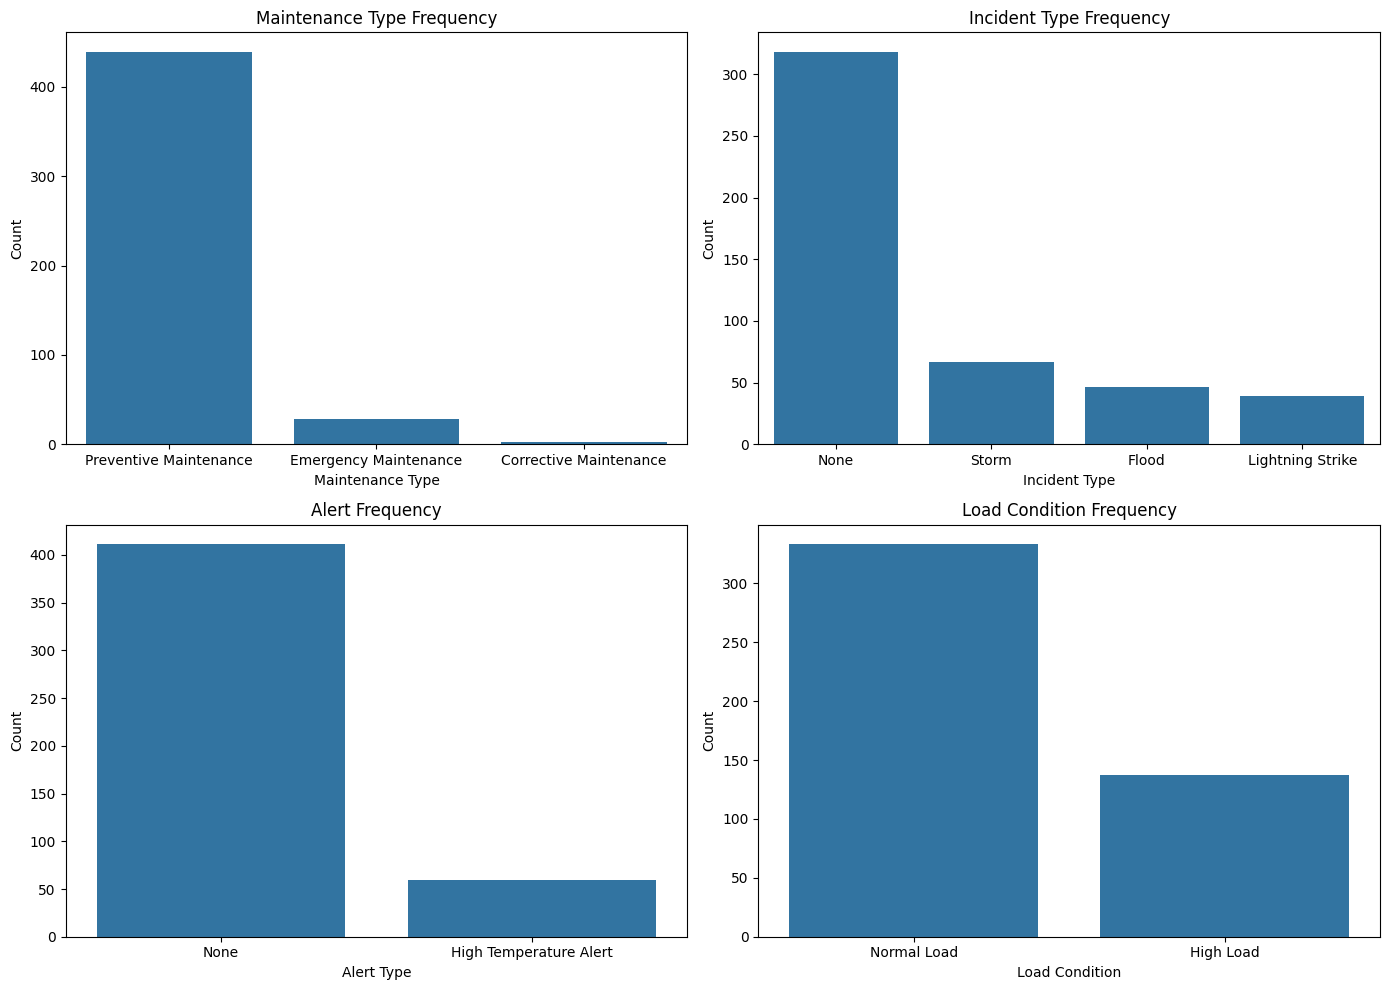

In [17]:
# 1. Analyze Maintenance Type Frequency
maintenance_type_counts = synthetic_data['MaintenanceType'].value_counts()

# 2. Analyze Incident Type Frequency (focusing on non-"None" incidents)
incident_type_counts = synthetic_data['IncidentType'].value_counts()

# 3. Analyze Alerts Frequency
alerts_counts = synthetic_data[synthetic_data['Alerts'] != '']['Alerts'].value_counts()

# 4. Analyze Load Condition Frequency
load_condition_counts = synthetic_data['LoadCondition'].value_counts()

# Set up the plot grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot maintenance type frequency
sns.barplot(x=maintenance_type_counts.index, y=maintenance_type_counts.values, ax=axs[0, 0])
axs[0, 0].set_title('Maintenance Type Frequency')
axs[0, 0].set_xlabel('Maintenance Type')
axs[0, 0].set_ylabel('Count')

# Plot incident type frequency
sns.barplot(x=incident_type_counts.index, y=incident_type_counts.values, ax=axs[0, 1])
axs[0, 1].set_title('Incident Type Frequency')
axs[0, 1].set_xlabel('Incident Type')
axs[0, 1].set_ylabel('Count')

# Plot alerts frequency
sns.barplot(x=alerts_counts.index, y=alerts_counts.values, ax=axs[1, 0])
axs[1, 0].set_title('Alert Frequency')
axs[1, 0].set_xlabel('Alert Type')
axs[1, 0].set_ylabel('Count')

# Plot load condition frequency
sns.barplot(x=load_condition_counts.index, y=load_condition_counts.values, ax=axs[1, 1])
axs[1, 1].set_title('Load Condition Frequency')
axs[1, 1].set_xlabel('Load Condition')
axs[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [18]:
# Concatenate with the original dataset
augmented_data = pd.concat([health_index_data, synthetic_data], axis=1)
# Display the augmented data 
augmented_data.head()

,Hydrogen,Oxigen,Nitrogen,Methane,CO,CO2,Ethylene,Ethane,Acethylene,DBDS,...,Temperature,Humidity,Precipitation,Alerts,IncidentType,IncidentDetails,OperationID,OperatingTime,LoadCondition,PerformanceMetrics
0,2845,5860,27842,7406,32,1344,16684,5467,7,19.0,...,83.597670,42.083960,15.846909,None,None,No incidents,OP-3509,39.416661,Normal Load,Performance with a load of 327.90248545686734 ...
1,12886,61,25041,877,83,864,4,305,0,45.0,...,58.271030,94.203417,39.936674,None,None,No incidents,OP-1616,38.320094,Normal Load,Performance with a load of 1037.2728204812988 ...
2,2820,16400,56300,144,257,1080,206,11,2190,1.0,...,58.892251,50.809745,20.301953,None,None,No incidents,OP-4139,38.296197,High Load,Performance with a load of 1579.9344904102502 ...
3,1099,70,37520,545,184,1402,6,230,0,87.0,...,28.849592,51.895361,46.499192,None,None,No incidents,OP-8875,38.296197,Normal Load,Performance with a load of 814.9848496434428 K...
4,3210,3570,47900,160,360,2130,4,43,4,1.0,...,38.966968,60.277677,0.148477,None,None,No incidents,OP-8798,38.284227,Normal Load,Performance with a load of 567.0171626278617 K...


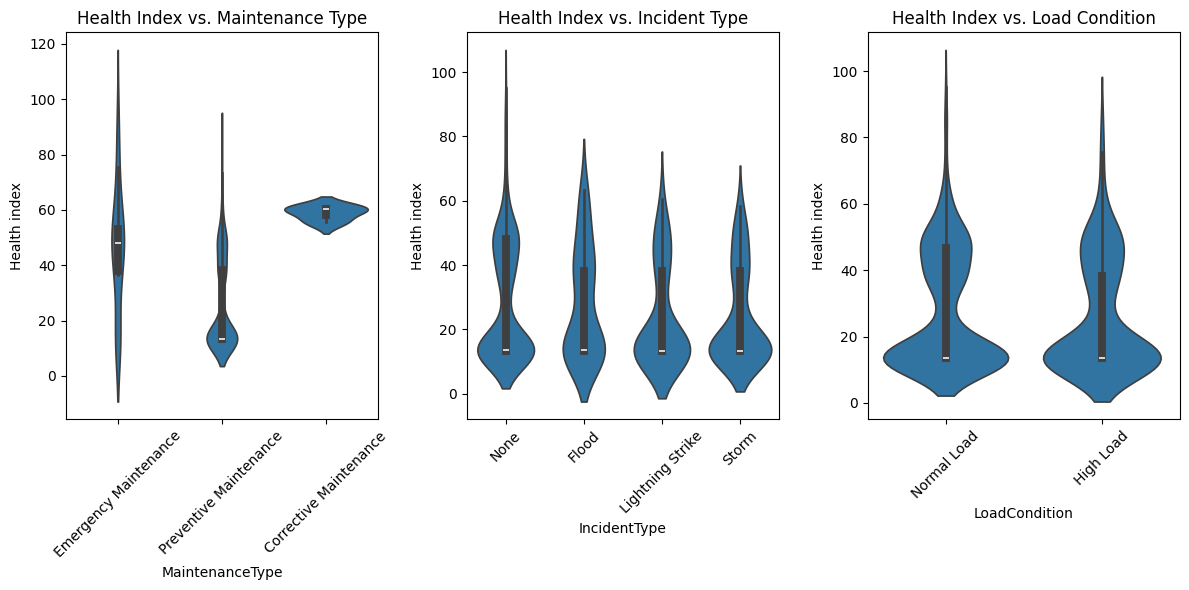

In [19]:
# Additionally, plot Health Index vs. categorical variables like MaintenanceType, IncidentType, LoadCondition
plt.figure(figsize=(12, 6))

# Boxplot for Maintenance Type
plt.subplot(1, 3, 1)
sns.violinplot(x='MaintenanceType', y='Health index', data=augmented_data)
plt.title('Health Index vs. Maintenance Type')
plt.xticks(rotation=45)

# Boxplot for Incident Type
plt.subplot(1, 3, 2)
sns.violinplot(x='IncidentType', y='Health index', data=augmented_data)
plt.title('Health Index vs. Incident Type')
plt.xticks(rotation=45)

# Boxplot for Load Condition
plt.subplot(1, 3, 3)
sns.violinplot(x='LoadCondition', y='Health index', data=augmented_data)
plt.title('Health Index vs. Load Condition')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

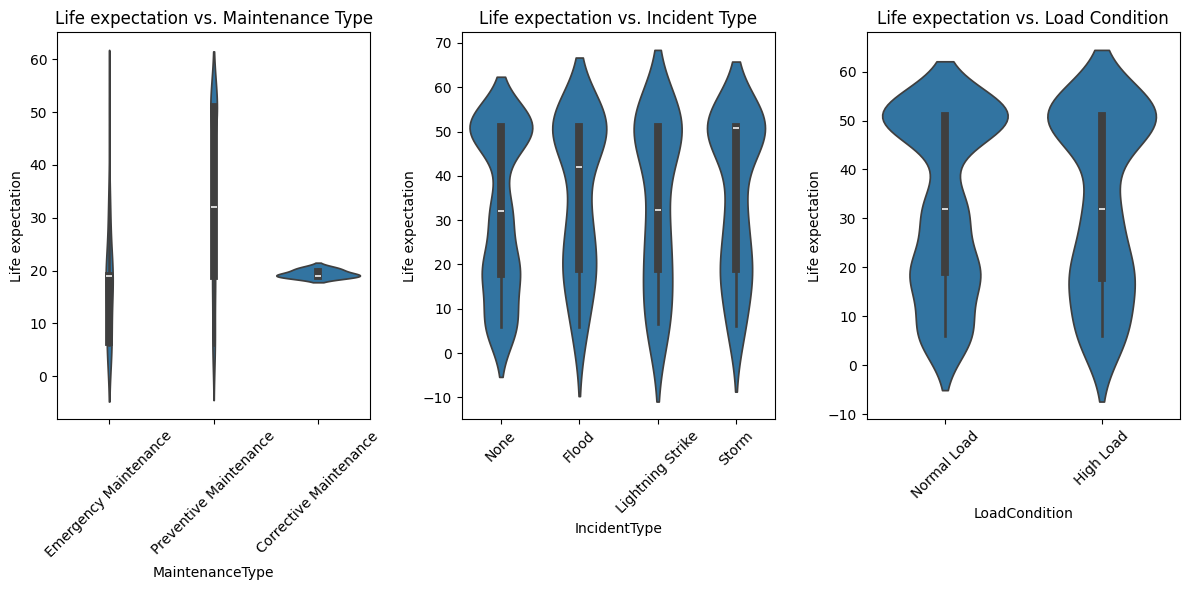

In [20]:
# Additionally, plot Life expectation vs. categorical variables like MaintenanceType, IncidentType, LoadCondition
plt.figure(figsize=(12, 6))

# Boxplot for Maintenance Type
plt.subplot(1, 3, 1)
sns.violinplot(x='MaintenanceType', y='Life expectation', data=augmented_data)
plt.title('Life expectation vs. Maintenance Type')
plt.xticks(rotation=45)

# Boxplot for Incident Type
plt.subplot(1, 3, 2)
sns.violinplot(x='IncidentType', y='Life expectation', data=augmented_data)
plt.title('Life expectation vs. Incident Type')
plt.xticks(rotation=45)

# Boxplot for Load Condition
plt.subplot(1, 3, 3)
sns.violinplot(x='LoadCondition', y='Life expectation', data=augmented_data)
plt.title('Life expectation vs. Load Condition')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [21]:
# save synthetic data to a csv file inside failure_data/ folder 
synthetic_data.to_csv("failure_data/synthetic_data.csv", index=False)

In [22]:
# save health_index_augdata data to a csv file inside failure_data/ folder 
augmented_data.to_csv("failure_data/health_index_augdata.csv", index=False)